 ### Supervised Learning Model for Motor Movement Prediction using Brain-Computer Interfaces

#### Load and Explore the EDF File

In [4]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

# List of files to process
edf_files = ["S001R01.edf", "S001R03.edf", "S001R04.edf"]

#### Defining Bandpass Filter for EEG Preprocessing

In [5]:
# Define bandpass filter function
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data, axis=1)

#### Initializing Storage for Merging Data

In [6]:
# Initialize empty lists for storing EEG data, labels, and session tracking
all_eeg_data = []
all_labels = []
all_sessions = []

#### Process Each EEG File

Processing S001R01.edf...
Extracting EDF parameters from c:\Users\angom\East Tennessee State University\Applied Data Science - AB - Documentos\Courses\Machine Learning\Project\EEG-Based Motor Intention Prediction\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Used Annotations descriptions: ['T0']
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>
Using matplotlib as 2D backend.


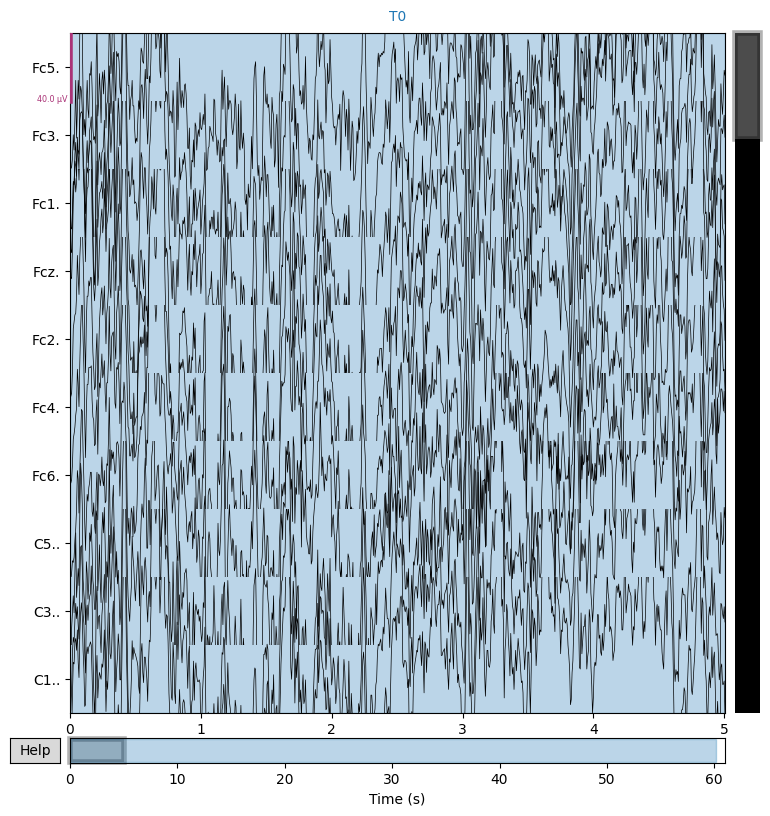

Processing S001R03.edf...
Extracting EDF parameters from c:\Users\angom\East Tennessee State University\Applied Data Science - AB - Documentos\Courses\Machine Learning\Project\EEG-Based Motor Intention Prediction\S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


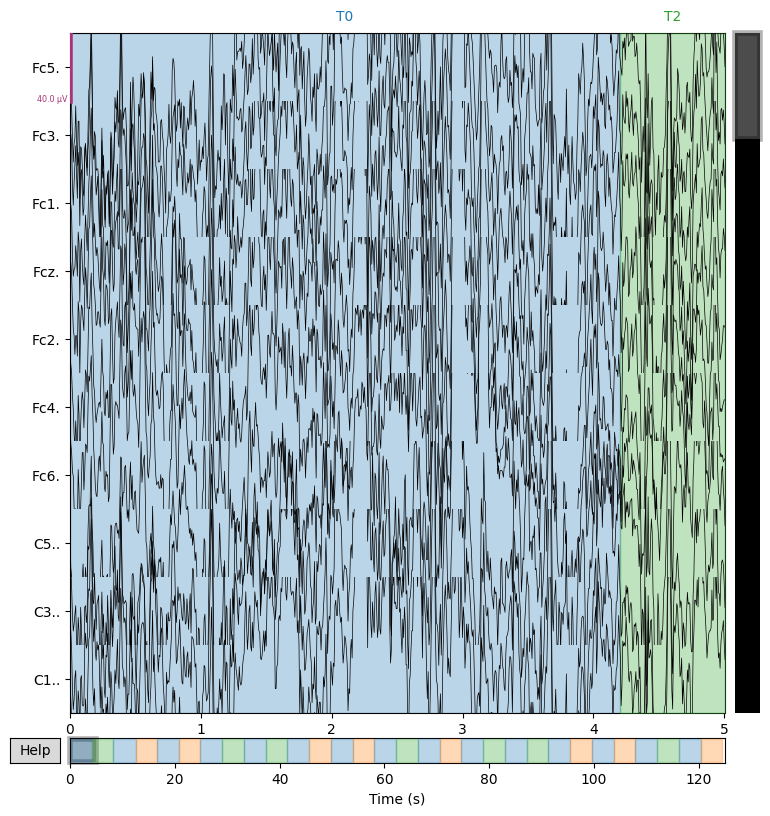

Processing S001R04.edf...
Extracting EDF parameters from c:\Users\angom\East Tennessee State University\Applied Data Science - AB - Documentos\Courses\Machine Learning\Project\EEG-Based Motor Intention Prediction\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


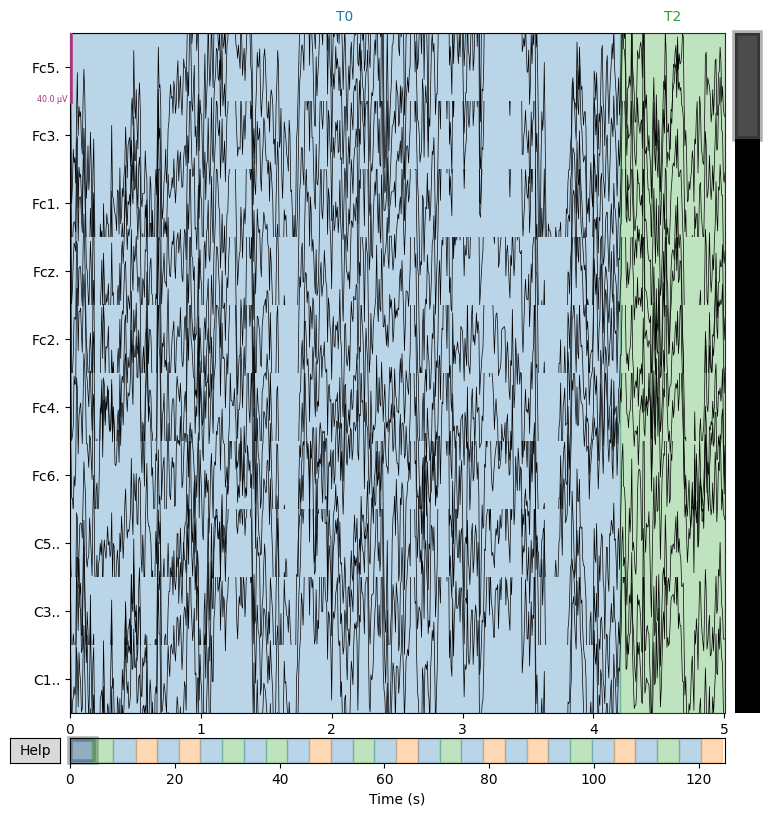

In [7]:
for edf_file in edf_files:
    print(f"Processing {edf_file}...")

    # Load EEG data from file
    raw = mne.io.read_raw_edf(edf_file, preload=True)
    events, event_dict = mne.events_from_annotations(raw)

    # Print EEG metadata
    print(raw.info)

    # Plot EEG signals (first 10 channels, 5 seconds)
    raw.plot(duration=5, n_channels=10)

    # Apply bandpass filter (1-40 Hz)
    filtered_data = butter_bandpass_filter(raw.get_data(), lowcut=1, highcut=40, fs=raw.info['sfreq'])

    # Store EEG and labels
    all_eeg_data.append(filtered_data)
    all_labels.append(events)
    all_sessions.append(np.full((filtered_data.shape[1],), edf_file))  # Track session

#### Merge All EEG Data Into One Dataset

In [8]:
# Concatenate EEG data from all sessions
merged_eeg = np.hstack(all_eeg_data)  # Merge along time axis
merged_sessions = np.concatenate(all_sessions)  # Merge session info

# Print shape of merged EEG dataset
print(f"Merged EEG Data Shape: {merged_eeg.shape}")  # (n_channels, total_time_samples)

Merged EEG Data Shape: (64, 49760)


#### Convert to DataFrame & Assign Labels

In [9]:
# Convert EEG data to DataFrame
df = pd.DataFrame(merged_eeg.T, columns=raw.ch_names)  # Transpose so rows = time samples

# Initialize movement labels (default = 0)
df["Movement_Label"] = 0

# Assign correct movement labels from event data
for i, event_list in enumerate(all_labels):
    for event in event_list:
        sample_idx, _, label = event
        df.loc[sample_idx:, "Movement_Label"] = label  # Assign labels at event points

# Add session info for tracking
df["Session"] = merged_sessions

#### Visualize Merged EEG Data

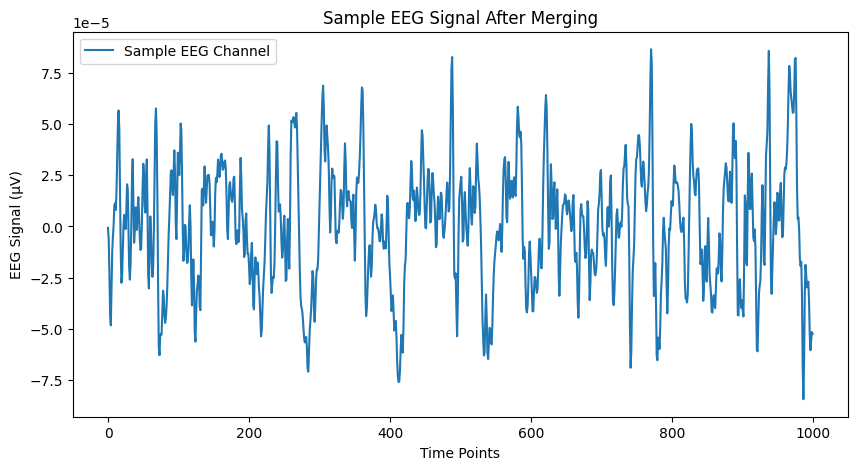

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(df.iloc[:1000, 0], label="Sample EEG Channel")  # Plot first channel
plt.xlabel("Time Points")
plt.ylabel("EEG Signal (µV)")
plt.title("Sample EEG Signal After Merging")
plt.legend()
plt.show()

#### Checking how many samples are labeled as T0, T1, and T2.

In [11]:
print(df["Movement_Label"].value_counts())

Movement_Label
2    35088
1    10080
3     4592
Name: count, dtype: int64


T0 (Rest) 

T1 (Movement) 

T2 (Movement)

#### Save Merged Data to CSV

In [12]:
# Save merged dataset as CSV
df.to_csv("merged_eeg_data.csv", index=False)

print("Merged EEG data saved as merged_eeg_data.csv")

Merged EEG data saved as merged_eeg_data.csv


#### Feature extraction

In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.signal import welch
from scipy.fft import fft
from mne.decoding import CSP  # Common Spatial Patterns


***Load Preprocessed EEG Data***

In [14]:
# Load the preprocessed EEG dataset
df = pd.read_csv("merged_eeg_data.csv")

# Separate EEG signals (features) and movement labels (targets)
X = df.iloc[:, :-2].values  # All EEG channels
y = df["Movement_Label"].values  # Movement labels
channels = df.columns[:-2]  # EEG channel names

***Compute Time-Domain Features***

In [15]:
def hjorth_parameters(eeg_signal):
    """ Compute Hjorth parameters: Activity, Mobility, Complexity """
    first_derivative = np.diff(eeg_signal)
    second_derivative = np.diff(first_derivative)

    activity = np.var(eeg_signal)
    mobility = np.sqrt(np.var(first_derivative) / activity)
    complexity = np.sqrt(np.var(second_derivative) / np.var(first_derivative))

    return activity, mobility, complexity

# Compute time-domain features for each channel
time_features = []

for i in range(X.shape[1]):  # Loop over channels
    channel_data = X[:, i]

    mean_val = np.mean(channel_data)
    variance_val = np.var(channel_data)
    rms_val = np.sqrt(np.mean(channel_data**2))
    hjorth_act, hjorth_mob, hjorth_comp = hjorth_parameters(channel_data)

    time_features.append([mean_val, variance_val, rms_val, hjorth_act, hjorth_mob, hjorth_comp])

# Convert to DataFrame
time_features_df = pd.DataFrame(time_features, columns=["Mean", "Variance", "RMS", "Hjorth_Activity", "Hjorth_Mobility", "Hjorth_Complexity"], index=channels)

# Display the first few rows of the DataFrame
print("Time-Domain Features:")
display(time_features_df)

# Save it as CSV for later use
time_features_df.to_csv("time_domain_features.csv", index=True)
print("Time-domain features saved as time_domain_features.csv")


Time-Domain Features:


,Mean,Variance,RMS,Hjorth_Activity,Hjorth_Mobility,Hjorth_Complexity
Fc5.,1.507611e-09,1.419974e-09,0.000038,1.419974e-09,0.387710,0.921347
Fc3.,6.057725e-11,1.547173e-09,0.000039,1.547173e-09,0.376559,0.881351
Fc1.,-1.791042e-09,1.611370e-09,0.000040,1.611370e-09,0.366584,0.871932
Fcz.,-2.576242e-09,1.623943e-09,0.000040,1.623943e-09,0.365716,0.877637
Fc2.,-8.131073e-10,1.514953e-09,0.000039,1.514953e-09,0.361650,0.877082
...,...,...,...,...,...,...
Po8.,8.393756e-09,1.484699e-09,0.000039,1.484699e-09,0.421514,0.907915
O1..,8.062708e-09,1.804420e-09,0.000042,1.804420e-09,0.413801,0.810141
Oz..,9.241722e-09,1.714862e-09,0.000041,1.714862e-09,0.427924,0.847385
O2..,1.042546e-08,1.868196e-09,0.000043,1.868196e-09,0.439146,0.864856


Time-domain features saved as time_domain_features.csv


***Compute Frequency-Domain Features***

In [16]:
def compute_psd(signal, fs=160):
    """ Compute Power Spectral Density (PSD) using Welch's method """
    freqs, psd_values = welch(signal, fs, nperseg=fs*2)
    return np.mean(psd_values)  # Return mean PSD as feature

# Compute FFT and PSD for each EEG channel
freq_features = []

for i in range(X.shape[1]):
    channel_data = X[:, i]

    # Compute FFT magnitude
    fft_vals = np.abs(fft(channel_data))
    fft_mean = np.mean(fft_vals)

    # Compute PSD
    psd_mean = compute_psd(channel_data)

    freq_features.append([fft_mean, psd_mean])

# Convert to DataFrame
freq_features_df = pd.DataFrame(freq_features, columns=["FFT_Mean", "PSD_Mean"], index=channels)

# Display Frequency-Domain Features
print("Frequency-Domain Features:")
display(freq_features_df)
freq_features_df.to_csv("frequency_domain_features.csv", index=True)
print("Frequency-domain features saved as frequency_domain_features.csv")


Frequency-Domain Features:


,FFT_Mean,PSD_Mean
Fc5.,0.004185,1.783021e-11
Fc3.,0.004319,1.941544e-11
Fc1.,0.004354,2.020097e-11
Fcz.,0.004366,2.027850e-11
Fc2.,0.004186,1.891996e-11
...,...,...
Po8.,0.004445,1.861207e-11
O1..,0.004797,2.266283e-11
Oz..,0.004754,2.151670e-11
O2..,0.005020,2.340665e-11


Frequency-domain features saved as frequency_domain_features.csv


***Compute Spatial Features (CSP)***

In [17]:
from mne.decoding import CSP

# Define trial length (e.g., 2 seconds per trial)
sfreq = 160  # Sampling frequency (Hz)
trial_length = 2  # Seconds
samples_per_trial = sfreq * trial_length  # Number of time points per trial

# Compute number of trials available
num_trials = X.shape[0] // samples_per_trial

# Reshape EEG data into (trials, channels, time_samples)
X_trials = X[:num_trials * samples_per_trial].reshape(num_trials, len(channels), samples_per_trial)

# Reshape labels (assign label per trial)
y_trials = y[:num_trials * samples_per_trial:samples_per_trial]

# Ensure labels match the number of trials
if X_trials.shape[0] != len(y_trials):
    raise ValueError("Mismatch in number of trials and labels!")

# Apply CSP
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
X_csp = csp.fit_transform(X_trials, y_trials)

# Convert to DataFrame
csp_df = pd.DataFrame(X_csp, columns=[f"CSP_{i+1}" for i in range(4)])

# Display CSP features
print("Spatial Features (CSP):")
display(csp_df)
csp_df.to_csv("spatial_features_csp.csv", index=True)
print("CSP features saved as spatial_features_csp.csv")

Computing rank from data with rank=None
    Using tolerance 0.0003 (2.2e-16 eps * 64 dim * 2.1e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.
Spatial Features (CSP):


,CSP_1,CSP_2,CSP_3,CSP_4
0,-0.250792,0.496230,0.688502,-2.492621
1,1.318472,-1.036527,-0.788893,-1.380543
2,-0.445343,-0.762802,-0.522497,-1.574479
3,-1.753108,-1.842257,-1.307880,-0.270498
4,-2.128529,-1.927870,-1.570716,0.311338
...,...,...,...,...
150,0.656287,-1.165884,0.460100,-0.844079
151,-0.323861,-0.615769,-1.099775,-1.868591
152,0.283365,-0.957483,0.214021,-1.421372
153,-0.549037,-0.519494,0.781009,-0.147591


CSP features saved as spatial_features_csp.csv


#### Merging All Features into a Single Dataset for Model Training

***Load All Extracted Feature Files***

In [18]:
import pandas as pd

# Load extracted features
time_features = pd.read_csv("time_domain_features.csv", index_col=0)  # Time-domain features
freq_features = pd.read_csv("frequency_domain_features.csv", index_col=0)  # Frequency-domain features
csp_features = pd.read_csv("spatial_features_csp.csv", index_col=0)  # CSP features

# Display shapes
print(f"Time Features Shape: {time_features.shape}")
print(f"Frequency Features Shape: {freq_features.shape}")
print(f"CSP Features Shape: {csp_features.shape}")

Time Features Shape: (64, 6)
Frequency Features Shape: (64, 2)
CSP Features Shape: (155, 4)


***Merge Features***

In [19]:
# Merge time & frequency features (both have 64 channels)
merged_static_features = pd.concat([time_features, freq_features], axis=1)

# Repeat static features for each CSP trial to match dimensions
merged_static_features_expanded = pd.concat([merged_static_features] * (csp_features.shape[0] // merged_static_features.shape[0]), ignore_index=True)

# Merge with CSP features
final_features = pd.concat([merged_static_features_expanded, csp_features], axis=1)

# Display shape
print(f"Final Features Shape: {final_features.shape}")

Final Features Shape: (155, 12)


***Adding Movement Labels***

In [20]:
# Load labels from the original EEG dataset
df = pd.read_csv("merged_eeg_data.csv")

# Extract movement labels per trial
sfreq = 160  # Sampling frequency
trial_length = 2  # Seconds
samples_per_trial = sfreq * trial_length

# Extract labels (one per trial)
num_trials = final_features.shape[0]
movement_labels = df["Movement_Label"].values[:num_trials * samples_per_trial:samples_per_trial]

# Attach labels to final dataset
final_features["Movement_Label"] = movement_labels

# Show preview
print(final_features.head())

           Mean      Variance       RMS  Hjorth_Activity  Hjorth_Mobility  \
0  1.507611e-09  1.419974e-09  0.000038     1.419974e-09         0.387710   
1  6.057725e-11  1.547173e-09  0.000039     1.547173e-09         0.376559   
2 -1.791042e-09  1.611370e-09  0.000040     1.611370e-09         0.366584   
3 -2.576242e-09  1.623943e-09  0.000040     1.623943e-09         0.365716   
4 -8.131073e-10  1.514953e-09  0.000039     1.514953e-09         0.361650   

   Hjorth_Complexity  FFT_Mean      PSD_Mean     CSP_1     CSP_2     CSP_3  \
0           0.921347  0.004185  1.783021e-11 -0.250792  0.496230  0.688502   
1           0.881351  0.004319  1.941544e-11  1.318472 -1.036527 -0.788893   
2           0.871932  0.004354  2.020097e-11 -0.445343 -0.762802 -0.522497   
3           0.877637  0.004366  2.027850e-11 -1.753108 -1.842257 -1.307880   
4           0.877082  0.004186  1.891996e-11 -2.128529 -1.927870 -1.570716   

      CSP_4  Movement_Label  
0 -2.492621               1  
1 -1.380

***Saving Final Dataset***

In [21]:
# Save the merged dataset for ML training
final_features.to_csv("final_features.csv", index=False)

print("Final dataset saved as final_features.csv")

Final dataset saved as final_features.csv


#### Feature scaling

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Load final dataset
df = pd.read_csv("final_features.csv")

# Separate features and labels
X = df.drop(columns=["Movement_Label"])  # Features
y = df["Movement_Label"]  # Labels

# Applying Standard Scaling (Mean=0, Variance=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame
scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
scaled_df["Movement_Label"] = y  # Reattach labels

# Display shape to verify
print(f"Scaled Dataset Shape: {scaled_df.shape}")

# Save scaled dataset for training
scaled_df.to_csv("scaled_final_features.csv", index=False)

print("Scaled dataset saved as scaled_final_features.csv")

Scaled Dataset Shape: (155, 13)
Scaled dataset saved as scaled_final_features.csv


#### Class Distribution Check (Detecting Imbalance)

Checking how many samples belong to each movement class (T0, T1, T2):

Class Distribution:
Movement_Label
2    108
1     32
3     15
Name: count, dtype: int64


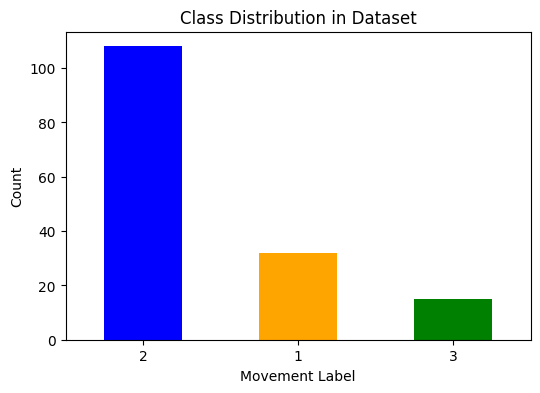

In [23]:
import pandas as pd

# Load scaled dataset
scaled_df = pd.read_csv("scaled_final_features.csv")

# Count occurrences of each movement label
class_counts = scaled_df["Movement_Label"].value_counts()

# Display class distribution
print("Class Distribution:")
print(class_counts)

# Visualize class balance
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
class_counts.plot(kind="bar", color=["blue", "orange", "green"])
plt.xlabel("Movement Label")
plt.ylabel("Count")
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=0)
plt.show()

The dataset is imbalanced at this point. This could lead to biased models favoring the majority class (class 2).

So, we will Consider handling this imbalance by using oversampling: SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic samples. Or Class Weights in model training to balance the effect of underrepresented classes.

#### Handling Class Imbalance with SMOTE (Synthetic Minority Over-sampling Technique)

Used to balance the classes, and prevent models from being biased toward the majority class, which can happen when the dataset is highly imbalanced.

Generates synthetic samples for underrepresented classes by interpolating between existing minority class instances.

We first need to double check if we have any missing values since SMOTE can fail if the dataset contains NaN (missing) values.

In [24]:
import pandas as pd

# Load the dataset
df = pd.read_csv("scaled_final_features.csv")

# Count missing values per column
missing_counts = df.isnull().sum()

# Display only columns with missing values
missing_counts = missing_counts[missing_counts > 0]

if missing_counts.empty:
    print("No missing values in the dataset!")
else:
    print("Missing Values Detected:")
    print(missing_counts)

Missing Values Detected:
Mean                 27
Variance             27
RMS                  27
Hjorth_Activity      27
Hjorth_Mobility      27
Hjorth_Complexity    27
FFT_Mean             27
PSD_Mean             27
dtype: int64


In [25]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Load the dataset
df = pd.read_csv("scaled_final_features.csv")

# Impute missing values using mean
imputer = SimpleImputer(strategy="mean")
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Save cleaned dataset
df_imputed.to_csv("cleaned_final_features.csv", index=False)

print("Cleaned dataset saved as cleaned_final_features.csv")

Cleaned dataset saved as cleaned_final_features.csv


In [26]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Load the cleaned dataset (after handling missing values)
df = pd.read_csv("cleaned_final_features.csv")

# Separate features and labels
X = df.drop(columns=["Movement_Label"])
y = df["Movement_Label"]

# Apply SMOTE to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to DataFrame
balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
balanced_df["Movement_Label"] = y_resampled  # Add the balanced labels

# Save the balanced dataset
balanced_df.to_csv("balanced_final_features.csv", index=False)

print("Balanced dataset saved as balanced_final_features.csv")

Balanced dataset saved as balanced_final_features.csv


***Checking the class distribution again to confirm that SMOTE worked.***

In [27]:
print("New Class Distribution:")
print(balanced_df["Movement_Label"].value_counts())

New Class Distribution:
Movement_Label
1.0    108
3.0    108
2.0    108
Name: count, dtype: int64


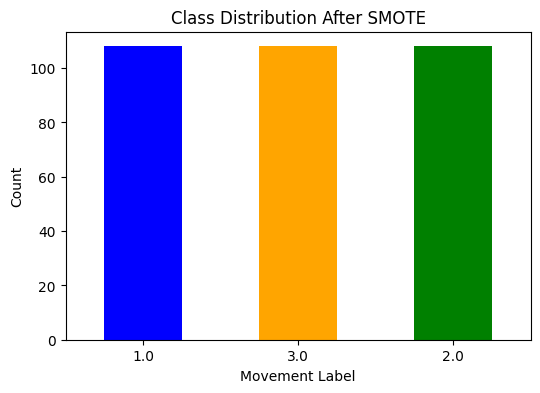

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the balanced dataset
balanced_df = pd.read_csv("balanced_final_features.csv")

# Plot the class distribution after SMOTE
plt.figure(figsize=(6, 4))
balanced_df["Movement_Label"].value_counts().plot(kind="bar", color=["blue", "orange", "green"])
plt.xlabel("Movement Label")
plt.ylabel("Count")
plt.title("Class Distribution After SMOTE")
plt.xticks(rotation=0)
plt.show()

##### Feature Importance Using Random Forest

Feature Importance Ranking:
              Feature  Importance
11              CSP_4    0.246686
8               CSP_1    0.193028
9               CSP_2    0.170086
10              CSP_3    0.102447
4     Hjorth_Mobility    0.054471
0                Mean    0.040353
5   Hjorth_Complexity    0.038235
1            Variance    0.038053
6            FFT_Mean    0.037075
3     Hjorth_Activity    0.030235
2                 RMS    0.025020
7            PSD_Mean    0.024312


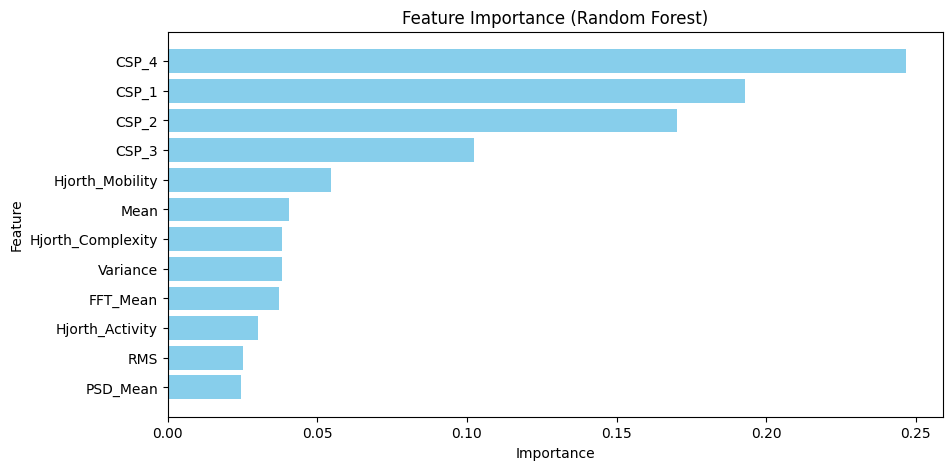

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# Separate features and labels
X = scaled_df.drop(columns=["Movement_Label"])  # Features
y = scaled_df["Movement_Label"]  # Labels

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
feature_importance = rf.feature_importances_

# Convert to DataFrame for visualization
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Display feature importance
print("Feature Importance Ranking:")
print(importance_df)

# Visualize feature importance
plt.figure(figsize=(10, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Random Forest)")
plt.gca().invert_yaxis()  # Highest importance at top
plt.show()

Features CSP_4, CSP_1, CSP_2, and CSP_3 contribute most to distinguishing movement labels.

Hjorth Mobility is also relatively influential, indicating its significance in EEG signal variability.

Other features have lower impact, but still contribute.

#### Splitting the data into Training & Testing sets 

In [30]:
from sklearn.model_selection import train_test_split

# Load the balanced dataset
balanced_df = pd.read_csv("balanced_final_features.csv")

# Separate features and labels
X = balanced_df.drop(columns=["Movement_Label"])
y = balanced_df["Movement_Label"]

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Save the split datasets
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Data split into training and testing sets.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Data split into training and testing sets.
Training set shape: (259, 12)
Testing set shape: (65, 12)


Training a Machine Learning Model (1st try with Random Forest Classifier)

Training Accuracy: 1.0000
Testing Accuracy: 0.9538

Classification Report (Test Set):
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        87
         2.0       1.00      1.00      1.00        86
         3.0       1.00      1.00      1.00        86

    accuracy                           1.00       259
   macro avg       1.00      1.00      1.00       259
weighted avg       1.00      1.00      1.00       259


Classification Report (Test Set):
              precision    recall  f1-score   support

         1.0       0.88      1.00      0.93        21
         2.0       1.00      0.86      0.93        22
         3.0       1.00      1.00      1.00        22

    accuracy                           0.95        65
   macro avg       0.96      0.95      0.95        65
weighted avg       0.96      0.95      0.95        65



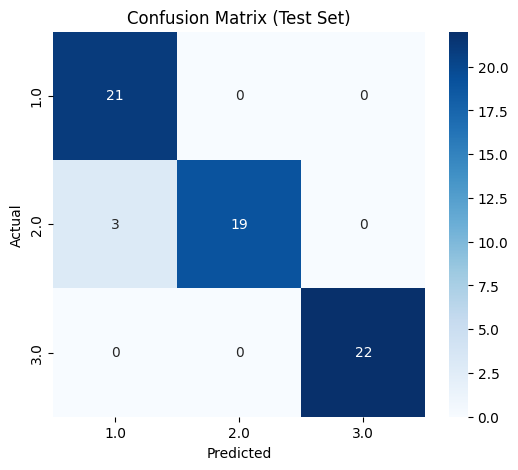

In [33]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on training and testing sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Evaluate the model on training and testing sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Classification report for test set
print("\nClassification Report (Test Set):")
print(classification_report(y_train, y_train_pred))

# Classification report for test set
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# Confusion matrix for test set
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.show()


C:\Users\angom\AppData\Local\Temp\ipykernel_6964\3555022966.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Training Accuracy", "Testing Accuracy"], y=[train_accuracy, test_accuracy], palette=["green", "blue"])


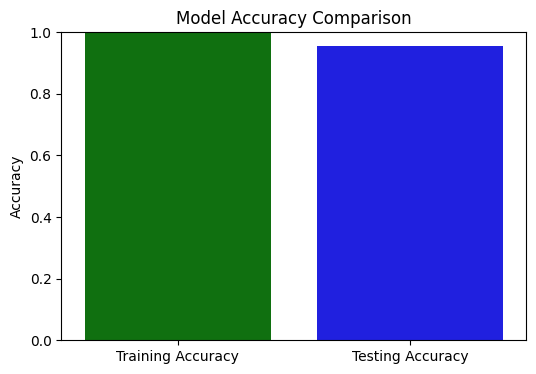

In [34]:
# Plot Training vs Testing Accuracy
plt.figure(figsize=(6, 4))
sns.barplot(x=["Training Accuracy", "Testing Accuracy"], y=[train_accuracy, test_accuracy], palette=["green", "blue"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

<Figure size 800x600 with 0 Axes>

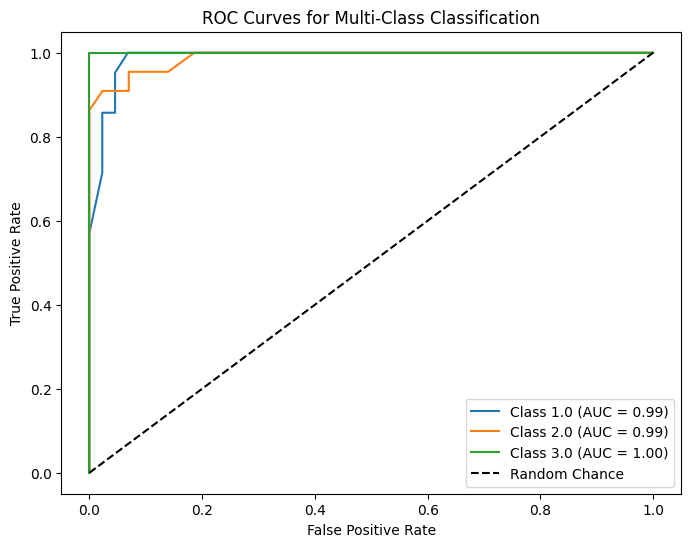

In [36]:
from sklearn.metrics import roc_curve, auc  # Import ROC functions

# Plot ROC Curves for Multi-Class Classification
plt.figure(figsize=(8, 6))
for i in range(len(rf_model.classes_)):
    fpr, tpr, _ = roc_curve(y_test == rf_model.classes_[i], rf_model.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {rf_model.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-Class Classification")
plt.legend()
plt.show()